In [48]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dense
from keras.optimizers import Adam

In [49]:
# Residual Block
def resd_block(x,filters, downsample=False):
  strides = (2,2) if downsample else (1,1)

  #1st conv layer
  y = Conv2D(filters,(3,3), strides, padding = 'same')(x)
  y = BatchNormalization()(y)
  y = Activation('relu')(y)

  #2nd conv layer
  y = Conv2D(filters,(3,3), strides, padding = 'same')(x)
  y = BatchNormalization()(y)

  # If downsample: shape is changed and same shapes can be added
  if downsample:
    x = Conv2D(filters,(1,1),(2,2),padding='same')(x)

  # Skip connection is added
  y = Add()([x,y])
  y = Activation('relu')(y)
  return y

  # ResNet Model
def resnet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x= Conv2D(16,(3,3),(1,1),padding='same')(inputs)
    x= BatchNormalization()(x)
    x= Activation('relu')(x)

    # Residual blocks
    x = resd_block(x,filters=16)
    x = resd_block(x,filters=16)
    x = resd_block(x,filters=32, downsample=True)
    x = resd_block(x,filters=32)
    x = resd_block(x,filters=64,downsample=True)
    x = resd_block(x,filters=64)
    x = resd_block(x,filters=128,downsample=True)
    x = resd_block(x,filters=128)
    x = resd_block(x,filters=256,downsample=True)
    x = resd_block(x,filters=256)
    x = resd_block(x,filters=512,downsample=True)
    x = resd_block(x,filters=512)

    # Output layer
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs,outputs=outputs)
    return model


In [ ]:
import gdown
url = "https://drive.google.com/file/d/12jiQxJzYSYl3wnC8x5wHAhRzzJmmsCXP/view?usp=sharing"
file_id = url.split("/")[-2]
print(file_id)
prefix = 'https://drive.google.com/uc?/export=download&id='
gdown.download(prefix+file_id, "catdog.zip")

12jiQxJzYSYl3wnC8x5wHAhRzzJmmsCXP


Downloading...
From: https://drive.google.com/uc?/export=download&id=12jiQxJzYSYl3wnC8x5wHAhRzzJmmsCXP
To: /content/catdog.zip
100%|██████████| 9.09M/9.09M [00:00<00:00, 189MB/s]


'catdog.zip'

In [ ]:
!unzip catdog.zip

Archive:  catdog.zip
replace train/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam


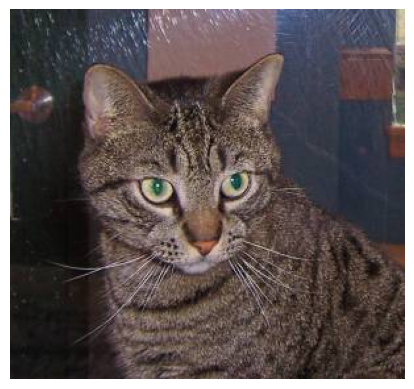

In [51]:
import matplotlib.pyplot as plt
from PIL import Image
# Specify the path to the image
image_path = '/content/train/Cat/1.jpg'

# Load and display the image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [58]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
train_data_dir = '/content/train'
validation_data_dir = '/content/validation'

# Set the number of training and validation samples
# num_train_samples = 2000
# num_validation_samples = 800

# Set the number of epochs and batch size
epochs = 10
batch_size = 64

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')

Found 337 images belonging to 2 classes.
Found 59 images belonging to 2 classes.


# **Implementing Model**


In [53]:
model = Sequential()
in_shape = (224,224,3)
resnet_model = resnet(in_shape,1)
for layer in resnet_model.layers:
    layer.trainable = False

model.add(resnet_model)
model.add(Dense(256, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 1)                 4905281   
                                                                 
 dense_7 (Dense)             (None, 256)               512       
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 4906050 (18.72 MB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 4905281 (18.71 MB)
_________________________________________________________________


In [54]:
import os

train_data_dir = '/content/train'

class_counts = {}

for class_folder in os.listdir(train_data_dir):
    if os.path.isdir(os.path.join(train_data_dir, class_folder)):
        class_path = os.path.join(train_data_dir, class_folder)
        num_samples = len(os.listdir(class_path))
        class_counts[class_folder] = num_samples


x=0
for class_name, count in class_counts.items():
    x += count

num_train_samples = x
num_train_samples

337

In [55]:
import os

validation_data_dir = '/content/validation'

class_counts_validation = {}

for class_folder in os.listdir(validation_data_dir):
    if os.path.isdir(os.path.join(validation_data_dir, class_folder)):
        class_path = os.path.join(validation_data_dir, class_folder)
        num_samples = len(os.listdir(class_path))
        class_counts_validation[class_folder] = num_samples
x=0
for class_name, count in class_counts_validation.items():
    x += count

num_validation_samples = x
num_validation_samples

59

In [60]:
history = model.fit(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps= 4)

# Save the trained model
model.save('dog_cat_classifier.h5')

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4719

5/5 [==============================] - 21s 4s/step - loss: 0.6936 - accuracy: 0.4719 - val_loss: 0.6932 - val_accuracy: 0.4915
Epoch 2/10
5/5 [==============================] - 13s 3s/step - loss: 0.6967 - accuracy: 0.4835
Epoch 3/10
5/5 [==============================] - 16s 3s/step - loss: 0.6917 - accuracy: 0.4906
Epoch 4/10
5/5 [==============================] - 13s 3s/step - loss: 0.6940 - accuracy: 0.5201
Epoch 5/10
5/5 [==============================] - 14s 3s/step - loss: 0.6916 - accuracy: 0.5238
Epoch 6/10
5/5 [==============================] - 13s 2s/step - loss: 0.6927 - accuracy: 0.5201
Epoch 7/10
5/5 [==============================] - 13s 3s/step - loss: 0.6905 - accuracy: 0.5458
Epoch 8/10
5/5 [==============================] - 15s 3s/step - loss: 0.6912 - accuracy: 0.5055
Epoch 9/10
5/5 [==============================] - 13s 2s/step - loss: 0.6939 - accuracy: 0.4982
Epoch 10/10
5/5 [==============================] - 13s 3s/step - loss: 0.6941 - accuracy: 0.5018


In [72]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to your custom image in Google Drive
custom_image_path = '/content/dog3.jpeg'

# Load and preprocess the image
img = image.load_img(custom_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0  # Normalize pixel values to [0, 1]

# Optionally, you can apply additional preprocessing steps if needed


In [73]:
predictions = model.predict(img_array)

if predictions[0, 0] > 0.5:
    print("Predicted class: Cat")
else:
    print("Predicted class: Dog")


1/1 [==============================] - 0s 56ms/step
Predicted class: Dog
